# <center>Optiver - Trading at the Close
<center>Predict US stocks closing movements
    <hr>

## <center>Group Members
<b><center>
Mahesh Jayaraman (mj456)<br>
Koushik Chandrasekaran (kc664)<br>
Saravana Prabhu Ramasamy (sr2484)<br>
<br>Course Instructor: Prof Daming Li
<hr>

We've split the notebook into 3 sections and they are:
1. EDA - Data Visualization
2. LSTM with feature expansion
3. LGBM with 5-fold CV

## Import Statements

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


<hr>

# Section 1: EDA - Data Visualization and Model Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from warnings import simplefilter

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [3]:
train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
train.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
num_stocks = len(train["stock_id"].unique())
num_days = len(train["date_id"].unique())

print(f"Number of Stocks = {num_stocks}")
print(f"Number of Days = {num_days}")

Number of Stocks = 200
Number of Days = 481


In [5]:
stock_100 = train[(train["stock_id"]==100) & (train["date_id"]==200)]
stock_100.head(4)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
2152360,100,200,0,0.0,0,0.999239,980038.36,NaN,NaN,0.999239,13635.00,1.000339,6078.8,1.000000,-9.980202,11000,200_0_100
2152559,100,200,10,0.0,0,1.001438,980038.36,NaN,NaN,1.001438,20998.55,1.002537,10032.0,1.002182,-10.120273,11001,200_10_100
2152758,100,200,20,0.0,0,0.999239,980038.36,NaN,NaN,0.999239,10908.00,1.000339,22704.5,0.999596,-9.899735,11002,200_20_100
2152957,100,200,30,0.0,0,0.998690,978218.97,NaN,NaN,0.998140,23916.72,0.999239,20907.0,0.998727,-1.879930,11003,200_30_100


Focus on stock with stock_id = 100 and on day 200


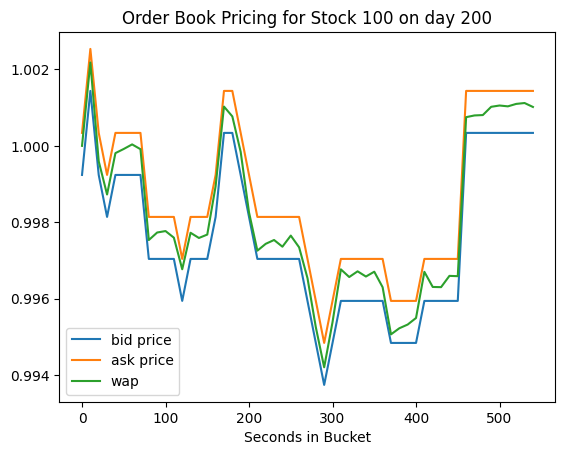

In [6]:
# Plotting the prices
plt.plot(stock_100["seconds_in_bucket"], stock_100["bid_price"], label="bid price")
plt.plot(stock_100["seconds_in_bucket"], stock_100["ask_price"], label="ask price")
plt.plot(stock_100["seconds_in_bucket"], stock_100["wap"], label="wap")
plt.title("Order Book Pricing for Stock 100 on day 200")
plt.xlabel("Seconds in Bucket")
plt.legend()
plt.show()

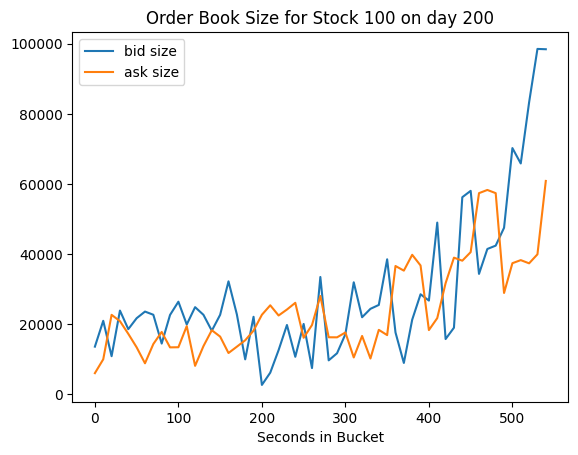

In [7]:
# Plotting the sizes

plt.plot(stock_100["seconds_in_bucket"], stock_100["bid_size"], label="bid size")
plt.plot(stock_100["seconds_in_bucket"], stock_100["ask_size"], label="ask size")
plt.title("Order Book Size for Stock 100 on day 200")
plt.xlabel("Seconds in Bucket")
plt.legend()
plt.show()

In [8]:
stock_100["volume"] = stock_100.eval("ask_size + bid_size")
stock_100["liquidity_imbalance"] = stock_100.eval("(bid_size-ask_size)/(bid_size+ask_size)")
stock_100["bid_ratio"] = stock_100.eval("bid_price/wap")
stock_100["ask_ratio"] = stock_100.eval("ask_price/wap")

stock_100.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wap,target,time_id,row_id,volume,liquidity_imbalance,bid_ratio,ask_ratio
2152360,100,200,0,0.0,0,0.999239,980038.36,NaN,NaN,0.999239,...,1.000339,6078.8,1.000000,-9.980202,11000,200_0_100,19713.80,0.383295,0.999239,1.000339
2152559,100,200,10,0.0,0,1.001438,980038.36,NaN,NaN,1.001438,...,1.002537,10032.0,1.002182,-10.120273,11001,200_10_100,31030.55,0.353411,0.999258,1.000354
2152758,100,200,20,0.0,0,0.999239,980038.36,NaN,NaN,0.999239,...,1.000339,22704.5,0.999596,-9.899735,11002,200_20_100,33612.50,-0.350956,0.999643,1.000743
2152957,100,200,30,0.0,0,0.998690,978218.97,NaN,NaN,0.998140,...,0.999239,20907.0,0.998727,-1.879930,11003,200_30_100,44823.72,0.067146,0.999412,1.000513
2153156,100,200,40,0.0,0,0.999239,980038.36,NaN,NaN,0.999239,...,1.000339,17290.0,0.999810,-14.070272,11004,200_40_100,35915.41,0.037182,0.999429,1.000529


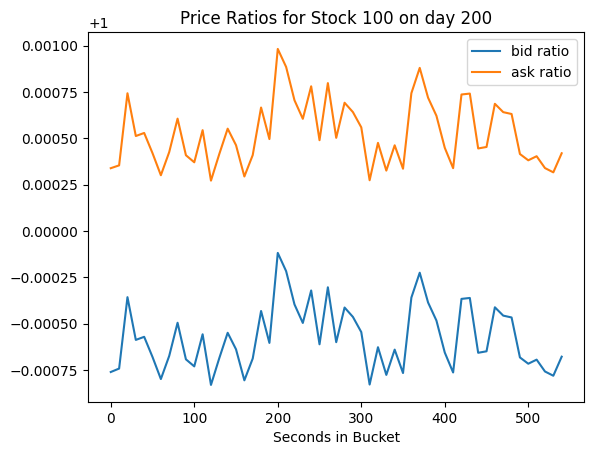

In [9]:
plt.plot(stock_100["seconds_in_bucket"], stock_100["bid_ratio"], label="bid ratio")
plt.plot(stock_100["seconds_in_bucket"], stock_100["ask_ratio"], label="ask ratio")
plt.title("Price Ratios for Stock 100 on day 200")
plt.xlabel("Seconds in Bucket")
plt.legend()
plt.show()

### Correlations

In [10]:
# Correlation between bid ratio and ask ratio
bid_ask_ratio_corr = stock_100.corr(method="spearman")["ask_ratio"]["bid_ratio"]
bid_ask_size_corr = stock_100.corr(method="spearman")["ask_size"]["bid_size"]

print(f"Correlation between bid ratio and ask ratio = {bid_ask_ratio_corr}")
print(f"Correlation between bid size and ask size = {bid_ask_size_corr}")

Correlation between bid ratio and ask ratio = 0.9995670995670995
Correlation between bid size and ask size = 0.2874201811032144


In [11]:
print("Correlations of various features with the target:")

stock_100.corr(method="spearman")["target"].sort_values(ascending=False)

Correlations of various features with the target:


target                     1.000000
volume                     0.350938
ask_size                   0.337272
seconds_in_bucket          0.295599
row_id                     0.295599
time_id                    0.295599
bid_size                   0.169267
matched_size               0.107942
ask_ratio                  0.069048
bid_ratio                  0.063781
imbalance_buy_sell_flag    0.029391
imbalance_size            -0.028012
liquidity_imbalance       -0.062266
near_price                -0.212434
far_price                 -0.212434
wap                       -0.331169
reference_price           -0.353622
bid_price                 -0.354938
ask_price                 -0.354938
stock_id                        NaN
date_id                         NaN
Name: target, dtype: float64

<hr>

# Section 2: LSTM with feature expansion

In [12]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [13]:
train_df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')

### Feature expansion

<li>The available features are limited. Additing more domain specific features would improve the training of the model.
<li>Creating a relative difference between the features as a new feature.

In [14]:
def feature_expansion(train_df):
    
    train_df['ba_rd'] = train_df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    train_df['im_rd'] = train_df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')
    
    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    
    # Combining 2 prices relative difference
    for i,first in enumerate(prices):
        for j,second in enumerate(prices):
            if i>j:
                train_df[f'{first}_{second}_rd'] = train_df.eval(f'({first}-{second})/({first}+{second})')
    
    # Comibing 3 prices relative difference
    for i,first in enumerate(prices):
        for j,second in enumerate(prices):
            for k,third in enumerate(prices):
                if i>j and j>k:
                    max_val = train_df[[first,second,third]].max(axis=1)
                    min_val = train_df[[first,second,third]].min(axis=1)
                    mid_val = train_df[[first,second,third]].sum(axis=1) - min_val - max_val

                    train_df[f'{first}_{second}_{third}_rd'] = (max_val - mid_val) / (mid_val - min_val)
    
    return train_df

In [15]:
# Generate expanded data
train_df_exp = feature_expansion(train_df)
train_df_exp.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,wap_far_price_reference_price_rd,wap_near_price_reference_price_rd,wap_near_price_far_price_rd,wap_ask_price_reference_price_rd,wap_ask_price_far_price_rd,wap_ask_price_near_price_rd,wap_bid_price_reference_price_rd,wap_bid_price_far_price_rd,wap_bid_price_near_price_rd,wap_bid_price_ask_price_rd
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,-1.000188,-1.000188,-1.0,0.138298,-1.000026,-1.000026,-1.693353e+12,-1.000188,-1.000188,0.138298
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,-1.000104,-1.000104,-1.0,6.346154,-1.000660,-1.000660,9.367487e+11,-1.000104,-1.000104,6.346154
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,-1.000439,-1.000439,-1.0,0.678815,-1.000298,-1.000298,2.778481e+00,-1.000597,-1.000597,0.499162
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,-1.000171,-1.000171,-1.0,0.251462,-1.000214,-1.000214,1.710000e+02,-1.000001,-1.000001,214.000000
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,-1.000468,-1.000468,-1.0,0.034188,-1.000016,-1.000016,3.391304e+00,-1.000606,-1.000606,0.026403


### Clearing Invalid data

In [16]:
min_values = train_df_exp.replace([np.inf, -np.inf], np.nan).min()
max_values = train_df_exp.replace([np.inf, -np.inf], np.nan).max()

# Replacing -inf, inf, and NaN
for column in train_df_exp.columns:
    if train_df_exp[column].dtype.kind in 'fc':
        # Replace -inf with half the minimum value of the column
        train_df_exp[column].replace(-np.inf, min_values[column] / 10, inplace=True)
        
        # Replace inf with twice the maximum value of the column
        train_df_exp[column].replace(np.inf, max_values[column] * 10, inplace=True)

# Replace NaN values with 0
train_df_exp.fillna(0, inplace=True)

print(train_df_exp.head(5))

   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                        1         0.999812   13380276.64        0.0   
1                       -1         0.999896    1642214.25        0.0   
2                       -1         0.999561    1819368.03        0.0   
3                       -1         1.000171   18389745.62        0.0   
4                       -1         0.999532   17860614.95        0.0   

   near_price  bid_price  ...  wap_far_price_reference_price_rd  \
0         0.0   0.999812  ...                         -1.000188   
1         0.0   0.999896  ...                         -1.000104   
2         0

In [17]:
# Summary of the newly updated data
train_df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 54 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   stock_id                                 int64  
 1   date_id                                  int64  
 2   seconds_in_bucket                        int64  
 3   imbalance_size                           float64
 4   imbalance_buy_sell_flag                  int64  
 5   reference_price                          float64
 6   matched_size                             float64
 7   far_price                                float64
 8   near_price                               float64
 9   bid_price                                float64
 10  bid_size                                 float64
 11  ask_price                                float64
 12  ask_size                                 float64
 13  wap                                      float64
 14  target            

### Viewing the relation between the values generated with target

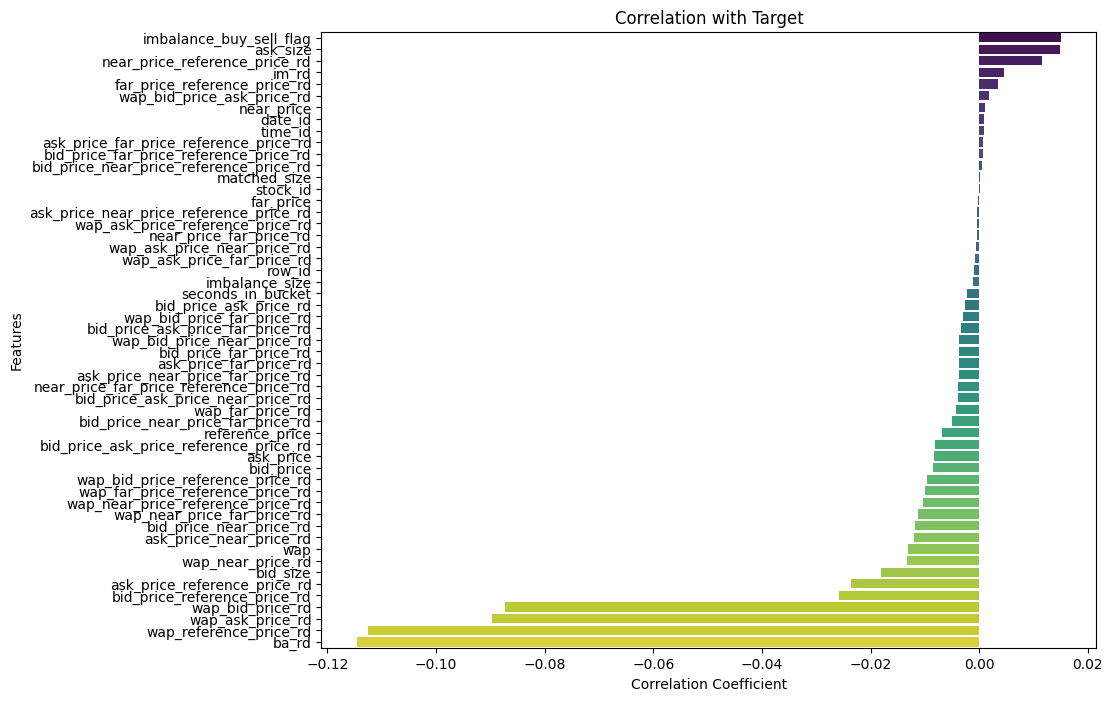

In [18]:
# Calculate the correlation of the target with the other columns
train_df_without_target = train_df_exp.copy()
train_df_without_target.pop("target")
relations = train_df_without_target.corrwith(train_df_exp['target']).sort_values(ascending=False)

# Visualize the correlations using a bar chart
plt.figure(figsize=(10, 8))
sns.barplot(y=relations.index, x=relations.values, palette='viridis')
plt.title('Correlation with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [19]:
# Required features
features = ["imbalance_buy_sell_flag", "ask_size", "near_price_reference_price_rd", "im_rd", "far_price_reference_price_rd", "wap_bid_price_ask_price_rd", "near_price", "date_id", "time_id",
            "ask_price_far_price_reference_price_rd", "bid_price_far_price_reference_price_rd", "bid_price_near_price_reference_price_rd",
           "matched_size", "stock_id", "far_price", "row_id", "imbalance_size", "seconds_in_bucket", "reference_price", "ask_price", "bid_price",
           "wap", "bid_size", "target"]
train_df_exp = train_df_exp[features]
train_df_exp.info()
print()
print("Added additional 6 feaures that would help boost the accuracy of the training")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 24 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   imbalance_buy_sell_flag                  int64  
 1   ask_size                                 float64
 2   near_price_reference_price_rd            float64
 3   im_rd                                    float64
 4   far_price_reference_price_rd             float64
 5   wap_bid_price_ask_price_rd               float64
 6   near_price                               float64
 7   date_id                                  int64  
 8   time_id                                  int64  
 9   ask_price_far_price_reference_price_rd   float64
 10  bid_price_far_price_reference_price_rd   float64
 11  bid_price_near_price_reference_price_rd  float64
 12  matched_size                             float64
 13  stock_id                                 int64  
 14  far_price         

### Convert categorical data to one-hot encoding

In [20]:
one_hot_encoded = pd.get_dummies(train_df_exp['imbalance_buy_sell_flag'], prefix='imbalance_buy_sell_flag')

# Concatenate the one-hot encoded columns with the original DataFrame
train_df_exp = pd.concat([train_df_exp, one_hot_encoded], axis=1)

# Drop the original categorical column if needed
train_df_exp.drop(['imbalance_buy_sell_flag'], axis=1, inplace=True)

# Display the updated DataFrame
print(train_df_exp.head(5))
train_df_exp.info()

    ask_size  near_price_reference_price_rd     im_rd  \
0    8493.03                            0.0 -0.615890   
1   20605.09                            0.0 -0.815787   
2   18995.00                            0.0 -0.714567   
3  479032.40                            0.0 -0.213547   
4     434.10                            0.0 -0.951109   

   far_price_reference_price_rd  wap_bid_price_ask_price_rd  near_price  \
0                           0.0                    0.138298         0.0   
1                           0.0                    6.346154         0.0   
2                           0.0                    0.499162         0.0   
3                           0.0                  214.000000         0.0   
4                           0.0                    0.026403         0.0   

   date_id  time_id  ask_price_far_price_reference_price_rd  \
0        0        0                               -1.000214   
1        0        0                               -1.000764   
2        0       

### Reduce Memory Usage

In [21]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    decrease = 100 * (start_mem - end_mem) / start_mem

    return df

train_df_exp = reduce_mem_usage(train_df_exp, verbose=1)
print(train_df_exp.head(5))

        ask_size  near_price_reference_price_rd     im_rd  \
0    8493.030273                            0.0 -0.615723   
1   20605.089844                            0.0 -0.815918   
2   18995.000000                            0.0 -0.714355   
3  479032.406250                            0.0 -0.213501   
4     434.100006                            0.0 -0.951172   

   far_price_reference_price_rd  wap_bid_price_ask_price_rd  near_price  \
0                           0.0                    0.138298         0.0   
1                           0.0                    6.346154         0.0   
2                           0.0                    0.499162         0.0   
3                           0.0                  214.000000         0.0   
4                           0.0                    0.026403         0.0   

   date_id  time_id  ask_price_far_price_reference_price_rd  \
0        0        0                               -1.000214   
1        0        0                               -1.000

### Building the LSTM model

In [22]:
from sklearn.preprocessing import StandardScaler

def create_sequences(data, sequence_length, step_size, no_target=False):
    sequences, targets = [], []
    scaler = StandardScaler()

    for stock_id, stock_data in data.groupby("stock_id"):
        # print(len(stock_data))
        if stock_id % 10 == 0:
            print(stock_id)
        stock_data = stock_data.sort_values(by=["time_id"])
        stock_data = stock_data.dropna()  # Drop rows with NaN values

        # Standardize numerical features
        stock_data[['ask_size', 'near_price_reference_price_rd', 'im_rd',
            'far_price_reference_price_rd', 'wap_bid_price_ask_price_rd', 'near_price',
            'imbalance_buy_sell_flag_-1', 'imbalance_buy_sell_flag_0', 'imbalance_buy_sell_flag_1']] = scaler.fit_transform(
            stock_data[['ask_size', 'near_price_reference_price_rd', 'im_rd',
            'far_price_reference_price_rd', 'wap_bid_price_ask_price_rd', 'near_price',
            'imbalance_buy_sell_flag_-1', 'imbalance_buy_sell_flag_0', 'imbalance_buy_sell_flag_1']])

        # Create sequences for each stock
        for i in range(0, len(stock_data) - sequence_length, step_size):
            sequence = stock_data.iloc[i:i + sequence_length][features].values
            target = stock_data.iloc[i + sequence_length]["target"]
            sequences.append(sequence)
            targets.append(target)
            
    return np.array(sequences), np.array(targets)

# Taking the top features with good corelation
features = ['ask_size', 'near_price_reference_price_rd', 'im_rd',
            'far_price_reference_price_rd', 'wap_bid_price_ask_price_rd', 'near_price',
            'imbalance_buy_sell_flag_-1', 'imbalance_buy_sell_flag_0', 'imbalance_buy_sell_flag_1']

sequence_length = 1 
step_size = 1
X_sequences, y_targets = create_sequences(train_df_exp, sequence_length, step_size)

print("X_sequences shape:", X_sequences.shape)
print("y_targets shape:", y_targets.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_targets, test_size=0.2, random_state=42, shuffle=False)

print(X_train.shape)
print(X_train[1])
print(y_train[1])
print(X_train.shape[1])
print(y_train.shape)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
X_sequences shape: (5237780, 1, 9)
y_targets shape: (5237780,)
(4190224, 1, 9)
[[-0.25728878  0.12994178 -0.37307432  0.11996455 -0.03789785 -0.9127219
  -0.9736231  -0.47188357  1.4208952 ]]
4.22
1
(4190224,)


In [23]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(units=1))
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,           # Reduce the learning rate by half
    patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,            # Set to 1 for logging updates
    min_lr=1e-6           # Minimum learning rate
)

In [24]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("keras_model.h5", save_best_only=True, verbose=1)
model.compile(keras.optimizers.Adamax(learning_rate=0.01, beta_1=0.9, beta_2=0.999), loss="mean_absolute_error",
             metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             12000     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 dense (Dense)               (None, 1, 1)              51        
                                                                 
Total params: 12051 (47.07 KB)
Trainable params: 12051 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
history = model.fit(X_train, y_train, epochs=20, batch_size=512,
                    validation_data=(X_test, y_test),
                   callbacks = [checkpoint_cb, lr_scheduler])

Epoch 1/20
8176/8185 [============================>.] - ETA: 0s - loss: 6.4856 - accuracy: 6.4881e-04
Epoch 1: val_loss improved from inf to 6.09570, saving model to keras_model.h5
8185/8185 [==============================] - 46s 5ms/step - loss: 6.4854 - accuracy: 6.4841e-04 - val_loss: 6.0957 - val_accuracy: 6.7490e-04 - lr: 0.0100
Epoch 2/20
8185/8185 [==============================] - ETA: 0s - loss: 6.4854 - accuracy: 6.4841e-04
Epoch 2: val_loss improved from 6.09570 to 6.09549, saving model to keras_model.h5
8185/8185 [==============================] - 40s 5ms/step - loss: 6.4854 - accuracy: 6.4841e-04 - val_loss: 6.0955 - val_accuracy: 6.7490e-04 - lr: 0.0100
Epoch 3/20
8176/8185 [============================>.] - ETA: 0s - loss: 6.4855 - accuracy: 6.4857e-04
Epoch 3: val_loss did not improve from 6.09549
8185/8185 [==============================] - 41s 5ms/step - loss: 6.4854 - accuracy: 6.4841e-04 - val_loss: 6.0956 - val_accuracy: 6.7490e-04 - lr: 0.0100
Epoch 4/20
8180/8185

### Submission

In [19]:
import optiver2023
env = optiver2023.make_env()

In [20]:
iter_test = env.iter_test()
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    test['near_price_reference_price_rd'] = test.eval('(near_price-reference_price)/(near_price+reference_price)')
    test['far_price_reference_price_rd'] = test.eval('(far_price-reference_price)/(far_price+reference_price)')
    
    max_val = test[['wap','bid_price','reference_price']].max(axis=1)
    min_val = test[['wap','bid_price','reference_price']].min(axis=1)
    mid_val = test[['wap','bid_price','reference_price']].sum(axis=1) - min_val - max_val
    test['wap_bid_price_ask_price_rd'] = (max_val - mid_val) / (mid_val - min_val)
    

    test['im_rd'] = test.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')
    one_hot_encoded = pd.get_dummies(test['imbalance_buy_sell_flag'], prefix='imbalance_buy_sell_flag')

    # Concatenate the one-hot encoded columns with the original DataFrame
    test = pd.concat([test, one_hot_encoded], axis=1)

    # Drop the original categorical column if needed
    test.drop(['imbalance_buy_sell_flag'], axis=1, inplace=True)
    for column in test.columns:
        if test[column].dtype.kind in 'fc':  # Check for float or complex dtypes
            # Replace -inf with half the minimum value of the column
            test[column].replace(-np.inf, min_values[column] / 10, inplace=True)

            # Replace inf with twice the maximum value of the column
            test[column].replace(np.inf, max_values[column] * 10, inplace=True)
    test.fillna(0, inplace=True)
    test = reduce_mem_usage(test)
    test = test[features].values
    
    test = test.reshape(test.shape[0], 1, test.shape[1])
    predictions = model.predict(test)

    sample_prediction['target'] = predictions.reshape(200, 1)

    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
7/7 [==============================] - 0s 2ms/step


<hr>

# Section 3: LightGBM with 5-fold Cross-Validation

In [1]:
import gc  
import os  
import time  
import warnings 
from itertools import combinations  
from warnings import simplefilter 
import joblib  
import lightgbm as lgb  
import numpy as np  
import pandas as pd  
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import KFold, TimeSeriesSplit  
import polars as pl
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

is_offline = False 
LGB = True
NN = False
is_train = True  
is_infer = True 
max_lookback = np.nan 
split_day = 435  

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Utilities

In [2]:
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return w

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [4]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
               
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df

## Data Loading

In [5]:
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")
df = df.dropna(subset=["target"])
df.reset_index(drop=True, inplace=True)
df_shape = df.shape

## Parallel Triplet Imbalance Calculation

In [6]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

## Feature Generation Functions

In [7]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1,3,5,10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'weighted_wap','price_spread']:
        for window in [1,3,5,10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
    
    #V4 feature
    for window in [3,5,10]:
        df[f'price_change_diff_{window}'] = df[f'bid_price_diff_{window}'] - df[f'ask_price_diff_{window}']
        df[f'size_change_diff_{window}'] = df[f'bid_size_diff_{window}'] - df[f'ask_size_diff_{window}']

    #V5 - rolling diff
    # Convert from pandas to Polars
    pl_df = pl.from_pandas(df)

    #Define the windows and columns for which you want to calculate the rolling statistics
    windows = [3, 5, 10]
    columns = ['ask_price', 'bid_price', 'ask_size', 'bid_size']

    # prepare the operations for each column and window
    group = ["stock_id"]
    expressions = []

    # Loop over each window and column to create the rolling mean and std expressions
    for window in windows:
        for col in columns:
            rolling_mean_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_mean(window)
                .over(group)
                .alias(f'rolling_diff_{col}_{window}')
            )

            rolling_std_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_std(window)
                .over(group)
                .alias(f'rolling_std_diff_{col}_{window}')
            )

            expressions.append(rolling_mean_expr)
            expressions.append(rolling_std_expr)

    # Run the operations using Polars' lazy API
    lazy_df = pl_df.lazy().with_columns(expressions)

    # Execute the lazy expressions and overwrite the pl_df variable
    pl_df = lazy_df.collect()

    # Convert back to pandas if necessary
    df = pl_df.to_pandas()
    gc.collect()
    
    df['mid_price*volume'] = df['mid_price_movement'] * df['volume']
    df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))')
    
    for col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], 0)

    return df

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    df['time_to_market_close'] = 540 - df['seconds_in_bucket']
    
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    gc.collect() 
    df = other_features(df)
    gc.collect()  
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]
    
    return df[feature_name]

In [8]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

## Data Splitting

In [9]:
if is_offline:
    
    df_train = df[df["date_id"] <= split_day]
    df_valid = df[df["date_id"] > split_day]
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")
    
else:
    df_train = df
    print("Online mode")

Online mode


In [10]:
if is_train:
    global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }
    if is_offline:
        df_train_feats = generate_all_features(df_train)
        print("Build Train Feats Finished.")
        df_valid_feats = generate_all_features(df_valid)
        print("Build Valid Feats Finished.")
        df_valid_feats = reduce_mem_usage(df_valid_feats)
    else:
        df_train_feats = generate_all_features(df_train)
        print("Build Online Train Feats Finished.")

    df_train_feats = reduce_mem_usage(df_train_feats)

Build Online Train Feats Finished.


## Model Training

## LGB

In [11]:
if LGB:
    import numpy as np
    import lightgbm as lgb
    
    lgb_params = {
        "objective": "mae",
        "n_estimators": 6000,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
#         "learning_rate": 0.00871,
        "learning_rate": 0.01,
        'max_depth': 11,
        "n_jobs": 4,
        "device": "gpu",
        "verbosity": -1,
        "importance_type": "gain",
#         "reg_alpha": 0.1,
        "reg_alpha": 0.2,
        "reg_lambda": 3.25
    }

    feature_columns = list(df_train_feats.columns)
    print(f"Features = {len(feature_columns)}")
    #print(f"Feature length = {len(feature_columns)}")

    num_folds = 5
    fold_size = 480 // num_folds
    gap = 5

    models = []
    models_cbt = []
    scores = []

    model_save_path = 'models' 
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    date_ids = df_train['date_id'].values

    for i in range(num_folds):
        start = i * fold_size
        end = start + fold_size
        if i < num_folds - 1:  # No need to purge after the last fold
            purged_start = end - 2
            purged_end = end + gap + 2
            train_indices = (date_ids >= start) & (date_ids < purged_start) | (date_ids > purged_end)
        else:
            train_indices = (date_ids >= start) & (date_ids < end)

        test_indices = (date_ids >= end) & (date_ids < end + fold_size)
        
        gc.collect()
        
        df_fold_train = df_train_feats[train_indices]
        df_fold_train_target = df_train['target'][train_indices]
        df_fold_valid = df_train_feats[test_indices]
        df_fold_valid_target = df_train['target'][test_indices]

        print(f"Fold {i+1} Model Training")

        # Train a LightGBM model for the current fold
        lgb_model = lgb.LGBMRegressor(**lgb_params)
        lgb_model.fit(
            df_fold_train[feature_columns],
            df_fold_train_target,
            eval_set=[(df_fold_valid[feature_columns], df_fold_valid_target)],
            callbacks=[
                lgb.callback.early_stopping(stopping_rounds=100),
                lgb.callback.log_evaluation(period=100),
            ],
        )
        

        models.append(lgb_model)
        # Save the model to a file
        model_filename = os.path.join(model_save_path, f'MKS-456_{i+1}.txt')
        lgb_model.booster_.save_model(model_filename)
        print(f"Model for fold {i+1} saved to {model_filename}")

        # Evaluate model performance on the validation set
        # LGB
        fold_predictions = lgb_model.predict(df_fold_valid[feature_columns])
        fold_score = mean_absolute_error(fold_predictions, df_fold_valid_target)
        scores.append(fold_score)
        print(f":LGB Fold {i+1} MAE: {fold_score}")

        # Free up memory by deleting fold specific variables
        del df_fold_train, df_fold_train_target, df_fold_valid, df_fold_valid_target
        gc.collect()

    # Calculate the average best iteration from all regular folds
    average_best_iteration = int(np.mean([model.best_iteration_ for model in models]))

    # Update the lgb_params with the average best iteration
    final_model_params = lgb_params.copy()

    # Train the final model on the entire dataset
    num_model = 1

    for i in range(num_model):
        final_model = lgb.LGBMRegressor(**final_model_params)
        final_model.fit(
            df_train_feats[feature_columns],
            df_train['target'],
            callbacks=[
                lgb.callback.log_evaluation(period=100),
            ],
        )
        # Append the final model to the list of models
        models.append(final_model)

Features = 160
Fold 1 Model Training
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 7.09169
[200]	valid_0's l1: 7.04838
[300]	valid_0's l1: 7.02504
[400]	valid_0's l1: 7.00523
[500]	valid_0's l1: 6.9893
[600]	valid_0's l1: 6.97601
[700]	valid_0's l1: 6.96391
[800]	valid_0's l1: 6.95314
[900]	valid_0's l1: 6.94292
[1000]	valid_0's l1: 6.934
[1100]	valid_0's l1: 6.92607
[1200]	valid_0's l1: 6.91789
[1300]	valid_0's l1: 6.91003
[1400]	valid_0's l1: 6.90263
[1500]	valid_0's l1: 6.89581
[1600]	valid_0's l1: 6.88908
[1700]	valid_0's l1: 6.88241
[1800]	valid_0's l1: 6.87618
[1900]	valid_0's l1: 6.86988
[2000]	valid_0's l1: 6.86375
[2100]	valid_0's l1: 6.85751
[2200]	valid_0's l1: 6.85115
[2300]	valid_0's l1: 6.84602
[2400]	valid_0's l1: 6.83996
[2500]	valid_0's l1: 6.83456
[2600]	valid_0's l1: 6.82877
[2700]	valid_0's l1: 6.82324
[2800]	valid_0's l1: 6.81796
[2900]	valid_0's l1: 6.81287
[3000]	valid_0's l1: 6.80749
[3100]	valid_0's l1: 6.8024
[3200]	valid_0'

## Neural Network

In [12]:
def create_mlp(num_continuous_features, num_categorical_features, embedding_dims, num_labels, hidden_units, dropout_rates, learning_rate,l2_strength=0.01):

    # Numerical variables input
    input_continuous = tf.keras.layers.Input(shape=(num_continuous_features,))

    # Categorical variables input
    input_categorical = [tf.keras.layers.Input(shape=(1,))
                         for _ in range(len(num_categorical_features))]

    # Embedding layer for categorical variables
    embeddings = [tf.keras.layers.Embedding(input_dim=num_categorical_features[i],
                                            output_dim=embedding_dims[i])(input_cat)
                  for i, input_cat in enumerate(input_categorical)]
    flat_embeddings = [tf.keras.layers.Flatten()(embed) for embed in embeddings]

    # concat numerical and categorical
    concat_input = tf.keras.layers.concatenate([input_continuous] + flat_embeddings)

    # MLP
    x = tf.keras.layers.BatchNormalization()(concat_input)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)

    for i in range(len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i],kernel_regularizer=l2(0.01),kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        #x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rates[i+1])(x)

    #No activation
    out = tf.keras.layers.Dense(num_labels,kernel_regularizer=l2(0.01),kernel_initializer='he_normal')(x)

    model = tf.keras.models.Model(inputs=[input_continuous] + input_categorical, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model

In [13]:
if NN:
    import numpy as np
    from sklearn.metrics import mean_absolute_error
    import gc
    from sklearn.model_selection import KFold
    import tensorflow as tf
    import tensorflow.keras.backend as K
    import tensorflow.keras.layers as layers
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
    
    df_train_feats = df_train_feats.groupby('stock_id').apply(lambda group: group.fillna(method='ffill')).fillna(0)
    
    categorical_features = ["stock_id"]
    numerical_features = [column for column in list(df_train_feats) if column not in categorical_features]
    num_categorical_features = [len(df_train_feats[col].unique()) for col in categorical_features]

    nn_models = []

    batch_size = 64
    hidden_units = [128,128]
    dropout_rates = [0.1,0.1,0.1]
    learning_rate = 1e-5
    embedding_dims = [20]

    directory = '/kaggle/working/NN_Models/'
    if not os.path.exists(directory):
        os.mkdir(directory)

    pred = np.zeros(len(df_train['target']))
    scores = []
    gkf = PurgedGroupTimeSeriesSplit(n_splits = 5, group_gap = 5)


    for fold, (tr, te) in enumerate(gkf.split(df_train_feats,df_train['target'],df_train['date_id'])):

        ckp_path = os.path.join(directory, f'nn_Fold_{fold+1}.h5')

        X_tr_continuous = df_train_feats.iloc[tr][numerical_features].values
        X_val_continuous = df_train_feats.iloc[te][numerical_features].values

        X_tr_categorical = df_train_feats.iloc[tr][categorical_features].values
        X_val_categorical = df_train_feats.iloc[te][categorical_features].values

        y_tr, y_val = df_train['target'].iloc[tr].values, df_train['target'].iloc[te].values

        print("X_train_numerical shape:",X_tr_continuous.shape)
        print("X_train_categorical shape:",X_tr_categorical.shape)
        print("Y_train shape:",y_tr.shape)
        print("X_test_numerical shape:",X_val_continuous.shape)
        print("X_test_categorical shape:",X_val_categorical.shape)
        print("Y_test shape:",y_val.shape)

        print(f"Creating Model - Fold{fold}")
        model = create_mlp(len(numerical_features), num_categorical_features, embedding_dims, 1, hidden_units, dropout_rates, learning_rate)

        rlr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1, patience=3, verbose=0, min_delta=1e-4, mode='min')
        ckp = ModelCheckpoint(ckp_path, monitor='val_mean_absolute_error', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
        es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=1e-4, patience=10, mode='min', restore_best_weights=True, verbose=0)

        print(f"Fitting Model - Fold{fold}")
        model.fit((X_tr_continuous,X_tr_categorical), y_tr,
                  validation_data=([X_val_continuous,X_val_categorical], y_val),
                  epochs=200, batch_size=batch_size,callbacks=[ckp,es,rlr])

        output = model.predict((X_val_continuous,X_val_categorical), batch_size=batch_size * 4)

        pred[te] += model.predict((X_val_continuous,X_val_categorical), batch_size=batch_size * 4).ravel()

        score = mean_absolute_error(y_val, pred[te])
        scores.append(score)
        print(f'Fold {fold} MAE:\t', score)

        # Finetune 3 epochs on validation set with small learning rate
        print(f"Finetuning Model - Fold{fold}")
        model = create_mlp(len(numerical_features), num_categorical_features, embedding_dims, 1, hidden_units, dropout_rates, learning_rate / 100)
        model.load_weights(ckp_path)
        model.fit((X_val_continuous,X_val_categorical), y_val, epochs=5, batch_size=batch_size, verbose=0)
        model.save_weights(ckp_path)
        nn_models.append(model)

        K.clear_session()
        del model
        gc.collect()

    print("Average NN CV Scores:",np.mean(scores))

## Submission

In [14]:
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices) / np.sum(std_error)
    out = prices - std_error * step
    return out

if is_infer:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    counter = 0
    y_min, y_max = -64, 64
    qps, predictions = [], []
    cache = pd.DataFrame()

    # Weights for each fold model
    if LGB:
        lgb_model_weights = weighted_average(models)
        #cbt_model_weights = weighted_average(models_cbt)
    
    for (test, revealed_targets, sample_prediction) in iter_test:
        now_time = time.time()
        cache = pd.concat([cache, test], ignore_index=True, axis=0)
        if counter > 0:
            cache = cache.groupby(['stock_id']).tail(21).sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)
        feat = generate_all_features(cache)[-len(test):]
        print(f"Feat Shape is: {feat.shape}")

        # Generate predictions for each model and calculate the weighted average
        if LGB:
            lgb_predictions = np.zeros(len(test))
            for model, weight in zip(models, lgb_model_weights):
                lgb_predictions += weight * model.predict(feat[feature_columns])

        predictions = lgb_predictions
        
        #Using mean predictions rather than zero sum
        final_predictions = predictions - np.mean(predictions)
        clipped_predictions = np.clip(final_predictions, y_min, y_max)
        sample_prediction['target'] = clipped_predictions
        env.predict(sample_prediction)
        counter += 1
        qps.append(time.time() - now_time)
        if counter % 10 == 0:
            print(counter, 'qps:', np.mean(qps))

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to run")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
10 qps: 1.407236433029175
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
20 qps: 1.3582592368125916
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
30 qps: 1.3567883888880412
Feat Shape is: 

# Key Results and Observation

### Mean Absolute Error using test dataset for LSTM with feature extraction = 5.4719
### Mean Absolute Error using test dataset for LGBM with 5-fold CV = 5.3359

![LSTM results](sc2.jpg "LSTM results")

![LGB results](sc1.png "LGB results")

| Factor | LSTM | LightGBM |
|--------|------|----------|
| **Model Complexity vs. Suitability** | Complex, best for sequential data. Less effective if sequence isn't main driver. | Less complex, handles diverse data types efficiently. More suitable for stock predictions. |
| **Feature Representation** | Needs effective feature engineering for time patterns. Performance suffers if not optimal. | Autonomously uncovers complex relationships in a range of features, vital for stock predictions. |
| **Overfitting Risk** | Prone to overfitting, especially with noisy, non-stationary financial data. | Better at managing overfitting, particularly with cross-validation, leading to improved generalization. |
| **Handling Data Noise and Volatility** | May misinterpret noise as significant patterns, affected by data volatility. | Robust to noise and volatility, often leads to better performance in noisy market data. |
| **Hyperparameter Tuning** | Performance heavily depends on tuning. Poor tuning leads to lesser performance. | Performance heavily influenced by hyperparameters. Well-tuned models perform better. |
| **Data Training and Validation** | Lacks robust validation, effectiveness may not be accurately assessed. | Benefits from 5-fold cross-validation, ensuring reliable performance estimation. |
| **Simplicity and Interpretability** | Complexity can be a drawback in less complex scenarios. Less interpretable. | Simpler and more interpretable, aiding in better tuning and performance. |

<b> In summary, LightGBM's simplicity, robustness to various data types, and effective overfitting management make it a more fitting choice for stock movement predictions, especially in cases like the Optiver Trading dataset. This dataset may not greatly benefit from the sequential modeling approach of LSTMs.